In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'
NROWS = 20000

In [2]:
PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'
trades = pd.read_csv(f"{PATH_TO_FILE}trades.csv") #[:3000000]
lobs = pd.read_csv(f"{PATH_TO_FILE}lobs.csv") #[:300000]

In [3]:
size_distribution = trades['size'].values
size_distribution = np.sort(size_distribution)[::-1]

Хотим оценить по Power Law параметр $-\alpha - 1$

Если предполагаем принадлежность степенному закону, то обычно говорят, что $\overline{F}(x) \sim x^{-\alpha}$ и оценивают $\gamma = \frac{1}{\alpha}$

Оценим $\gamma$ по оценке Хилла: $\frac{1}{k} \sum_{i = 1}^{k} ln\left(\frac{X_{(n-i+1)}}{X_{(n-k)}}\right)$

In [4]:
hill_estimators = []
k = 10
hill_estimators.append(np.log(size_distribution[:k]).mean() - np.log(size_distribution[k]))
last_order_statistic = np.log(size_distribution[k])
for i in tqdm(range(11, 200000)):
    hill_estimators.append((hill_estimators[-1]*(i-1) + i*last_order_statistic - i*np.log(size_distribution[i]))/i)
    last_order_statistic = np.log(size_distribution[i])

100%|██████████| 199989/199989 [00:00<00:00, 335074.59it/s]


No handles with labels found to put in legend.


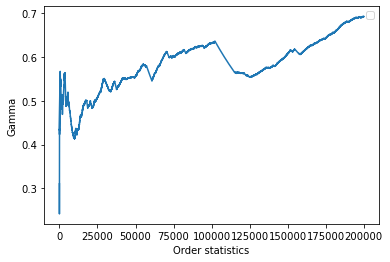

In [5]:
plt.plot(hill_estimators[:200000])
plt.xlabel("Order statistics")
plt.ylabel("Gamma")
plt.legend()

Данные не подгоняются к Power Law: обычно в таком случае ожидается график как снизу - значение гаммы стабилизируется

In [6]:
from scipy.stats import pareto
ran_vals = np.sort(pareto.rvs(size = 1000000, b = 4))[::-1]
hill_estimators = []
k = 10
hill_estimators.append(np.log(ran_vals[:k]).mean() - np.log(ran_vals[k]))
last_order_statistic = np.log(ran_vals[k])
for i in tqdm(range(11, 200000)):
    hill_estimators.append((hill_estimators[-1]*(i-1) + i*last_order_statistic - i*np.log(ran_vals[i]))/i)
    last_order_statistic = np.log(ran_vals[i])


100%|██████████| 199989/199989 [00:00<00:00, 340017.77it/s]


No handles with labels found to put in legend.


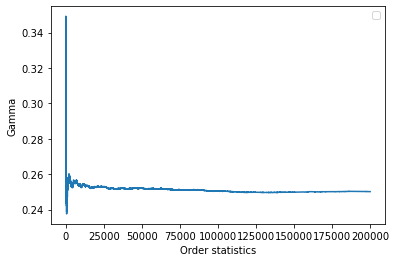

In [7]:
plt.plot(hill_estimators[:200000])
plt.xlabel("Order statistics")
plt.ylabel("Gamma")
plt.legend()

In [8]:
tqdm.pandas()

Основные параметры, которые нужно оценить: это k и A в интенсивности: $\lambda(\delta) = Ae^{-k\delta}$
Тогда $log(\lambda(\delta)) = -k\delta + log(A)$

Интенсивность исполнения определим, как количество трейдов, пробивших уровень $\delta$
Таким образом, получаем лин. зависимость между $\log(\#trades)$ и $\delta$

Идея описана на стр.8 в этой статье: http://events.chairefdd.org/wp-content/uploads/2013/06/CAHIER_MICRO_1.pdf

In [9]:
trades_bid = trades.groupby('aggro_side').get_group('BID').groupby('exchange_ts').agg({'receive_ts': ['count'], 'size': ['sum'], 'price': ['first', 'last']})
trades_ask = trades.groupby('aggro_side').get_group('ASK').groupby('exchange_ts').agg({'receive_ts': ['count'], 'size': ['sum'], 'price': ['first', 'last']})

trades_bid.columns = trades_bid.columns.map('_'.join)
trades_ask.columns = trades_ask.columns.map('_'.join)

trades_bid['diff'] = trades_bid.price_last - trades_bid.price_first
trades_ask['diff'] = trades_ask.price_last - trades_ask.price_first

In [10]:
trades_bid

,receive_ts_count,size_sum,price_first,price_last,diff
exchange_ts,,,,,
1655942402623000000,1,0.001,19977.5,19977.5,0.0
1655942405292000000,7,0.086,19977.5,19978.0,0.5
1655942409193000000,4,0.150,19978.0,19978.0,0.0
1655942409198000000,1,0.199,19978.0,19978.0,0.0
1655942409202000000,3,0.167,19978.0,19978.0,0.0
...,...,...,...,...,...
1656028780864000000,1,0.001,21089.0,21089.0,0.0
1656028781043000000,2,0.003,21089.0,21089.1,0.1
1656028781055000000,1,0.001,21089.1,21089.1,0.0


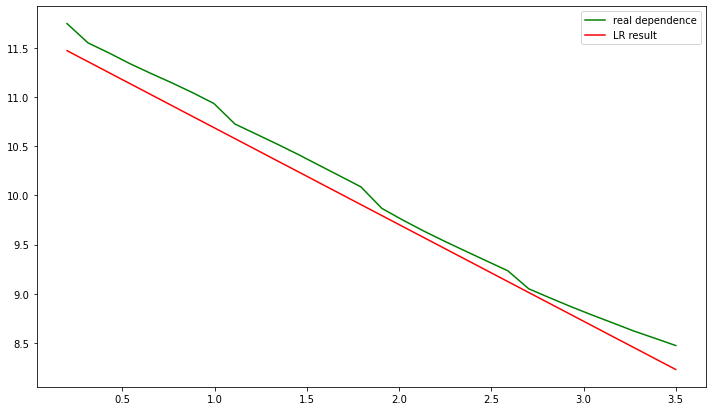

In [11]:
from sklearn.linear_model import LinearRegression

grid = 30
diffs = trades_bid['diff'].values

deltas = np.linspace(0.2, 3.5, grid)

res = np.zeros(grid)

for i in range(grid):
    res[i] = diffs[diffs >= deltas[i]].shape[0]

res = np.log(res).reshape(-1,1)
deltas = deltas.reshape(-1,1)

model = LinearRegression().fit(res, deltas)
    
slope = model.coef_

intercept = model.intercept_

plt.figure(figsize=(12, 7))
plt.plot(deltas, res, '-g', label = "real dependence")
plt.plot(deltas, slope*deltas + intercept, '-r', label ="LR result")
plt.legend()

In [12]:
slope, intercept

(array([[-0.98121991]]), array([11.6656336]))

Тогда считаем k примерно 1, а $A = e^{11.6}$

In [28]:
k = 1
A = np.exp(11.6)

$dS_t = \sigma dW_t$
Тогда $dS_t \sim N(0, \sigma^2 dt), \frac{dS_t}{\sqrt{dt}} \sim N(0, \sigma^2)$

In [29]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [30]:
last_timestamp = 0
last_price = 0
data = []
for snapshot in md:
    if snapshot.orderbook != None:
        if last_timestamp != 0:
            delta_times = snapshot.orderbook.exchange_ts*1e-9 - last_timestamp
            data.append(((snapshot.orderbook.asks[0][0] + snapshot.orderbook.bids[0][0])/2 - last_price)/np.sqrt(delta_times))
        else: 
            last_timestamp = snapshot.orderbook.exchange_ts*1e-9
            last_price = (snapshot.orderbook.asks[0][0] + snapshot.orderbook.bids[0][0])/2

In [31]:
sigma = np.std(data)

In [32]:
sigma #в секунду

2.533900800194919

In [33]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [34]:
#delay between orders
delay = pd.Timedelta(0.05, 's').delta

hold_time = pd.Timedelta(10, 's').delta

pnl = {}
T = 1
for gamma in [0.05, 0.1, 0.2, 0.4, 0.5, 0.8, 1]:
    print(gamma)
    sim = Sim(md, latency, md_latency)
    strategy = BestPosStrategy(delay, hold_time, k, sigma, A, gamma, T)
    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    pnl[gamma] = get_pnl(updates_list)['USD']
    

0.05
0.1
0.2
0.4
0.5
0.8
1


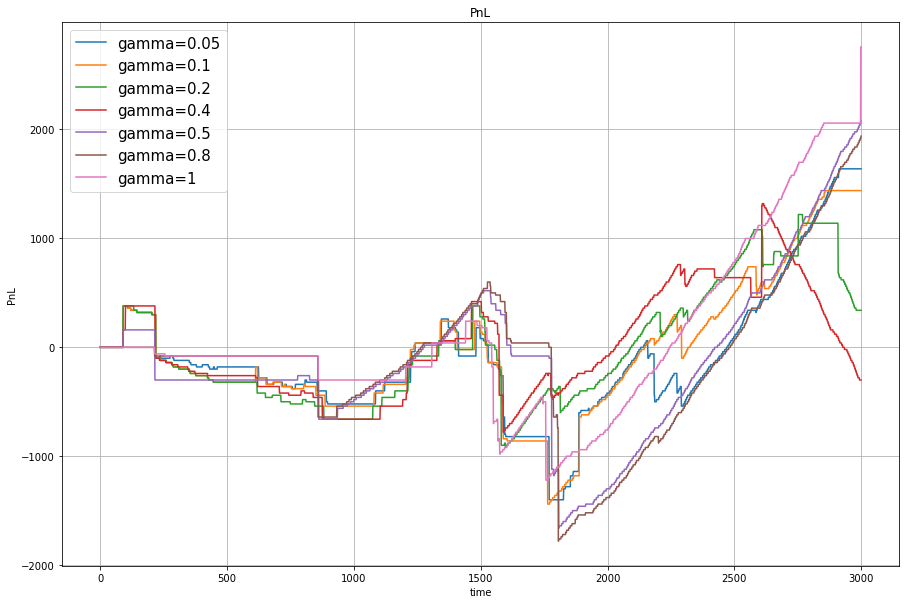

In [35]:
plt.figure(figsize=(15, 10))

for gamma in [0.05, 0.1, 0.2, 0.4, 0.5, 0.8, 1]:
    
    plt.plot(pnl[gamma][:3000], '-', label=f'gamma={gamma}')

plt.xlabel("time")
plt.ylabel("PnL")
plt.title("PnL")
plt.legend(fontsize=15)
plt.grid()
plt.show()